In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os; print(os.getcwd())
import socket; print(socket.gethostname())

/home/ajasja/projects/truncator
dig33


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

from glob import glob
import truncator



In [3]:
#import sys; sys.path.insert(0, "/home/ajasja/projects/Stable_Heterodimers")
#import utils as u

In [4]:
score_files = sorted(glob("out/R3/03_score/*/*_IA.sc")); len(score_files)

6221

In [5]:
%%time
df = truncator.read_score_files_with_cache(score_files,"out/R3/03_score/IA_scores.csv.gzip" )
df = df.drop_duplicates(keep='last', subset=['decoy']).set_index('decoy', drop=False)
df['kind']='trunc'

CPU times: user 490 ms, sys: 90.8 ms, total: 581 ms
Wall time: 586 ms


/software/conda/envs/jupyterhub/lib/python3.6/site-packages/IPython/core/magic.py:187: DtypeWarning: Columns (103,105,107) have mixed types. Specify dtype option on import or set low_memory=False.
  call = lambda f, *a, **k: f(*a, **k)


In [6]:
%%time
score_files = sorted(glob("out/native/*_IA.sc")); len(score_files)
dfn = truncator.read_score_files_with_cache(score_files,"out/native/IA_scores.csv.gzip" )
dfn = dfn.drop_duplicates(keep='last', subset=['decoy']).set_index('decoy', drop=False)
dfn['kind']='native'

CPU times: user 41.7 ms, sys: 11.4 ms, total: 53.2 ms
Wall time: 103 ms


In [8]:
sc = pd.concat([df, dfn], sort=True)

In [9]:
sc['num_core_hbnet_residues_total']=sc['num_core_hbnet_residues_chA']+sc['num_core_hbnet_residues_chB']
sc['num_core_total']=sc['num_core_chA']+sc['num_core_chB']

In [10]:
sc['frx_total_exposed_hydrophobics']=sc['total_exposed_hydrophobics']/sc['total_SASA']
sc['chA_frx_total_exposed_hydrophobics']=sc['chA_exposed_hydrophobics']/sc['chA_SASA']
sc['chB_frx_total_exposed_hydrophobics']=sc['chB_exposed_hydrophobics']/sc['chB_SASA']
sc['interface_hpatch']=-sc['total_hpatch_score']+sc['chA_hpatch_score']+sc['chB_hpatch_score']
sc['interface_exposed_hydrophobics']=-sc['total_exposed_hydrophobics']+sc['chA_exposed_hydrophobics']+sc['chB_exposed_hydrophobics']

In [13]:
list(sc.columns)

['AB_interface_pymol_selection',
 'all_buns_bb',
 'all_buns_sc',
 'bndr_SASA_pymol_selection',
 'bndr_pymol_selection',
 'chA_SASA',
 'chA_core_SASA_polars_pymol_selection',
 'chA_exposed_hydrophobics',
 'chA_hpatch_score',
 'chA_hydrophobic_SASA',
 'chA_num_core_SASA_polars',
 'chA_polar_SASA',
 'chB_SASA',
 'chB_core_SASA_polars_pymol_selection',
 'chB_exposed_hydrophobics',
 'chB_hpatch_score',
 'chB_hydrophobic_SASA',
 'chB_num_core_SASA_polars',
 'chB_polar_SASA',
 'chainA_pymol_selection',
 'chainB_pymol_selection',
 'charge_chA',
 'charge_chB',
 'complex_normalized',
 'coreSASA_int_Hbonds_polar_pymol_selection',
 'coreSASA_int_Hbonds_pymol_selection',
 'core_Hbonds_pymol_selection',
 'core_SASA_polars_pymol_selection',
 'core_SASA_pymol_selection',
 'core_and_interface_by_vec_pymol_selection',
 'core_and_interface_pymol_selection',
 'core_bndr_Hbonds_pymol_selection',
 'core_bndr_and_interface_by_vec_pymol_selection',
 'core_bndr_polars_pymol_selection',
 'core_buns_bb',
 'core_

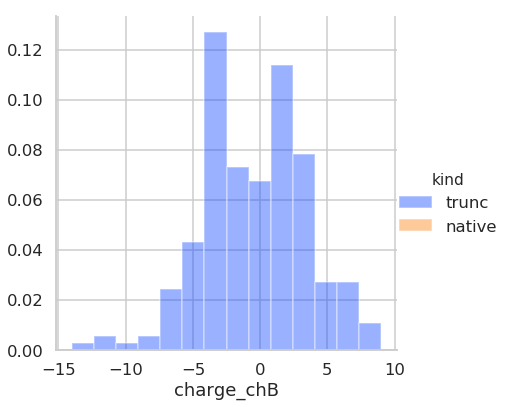

In [17]:
sns.set_style("whitegrid")
sns.set_context("talk")
def plot_hist(field_name):
    g = sns.FacetGrid(sc,  hue="kind", height=6, palette='bright')
    g = (g.map(sns.distplot, field_name, kde=False, norm_hist=True))
    g.add_legend()
    return g

plot_hist('charge_chB')

In [14]:
plot_hist('charge_chA')
#plt.xlim([-200, 200])

NameError: name 'plot_hist' is not defined

In [8]:
#print("\n".join(list(df.columns)));
cols = truncator.read_file_lines('col_order.list', skip_comments=True)
df = df[cols]


In [9]:
len(df)

6129

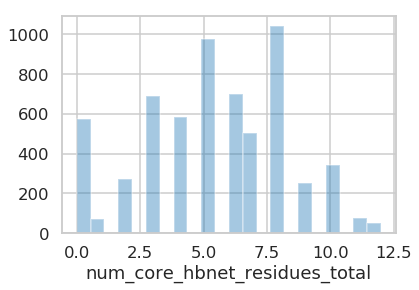

In [16]:

sns.distplot(df['num_core_hbnet_residues_total'].dropna(), kde=False)


In [11]:
df

,num_core_hbnet_residues_chA,num_core_hbnet_residues_chB,num_core_chA,num_core_chB,nres_all,nres_int,chA_SASA,chA_exposed_hydrophobics,chA_hpatch_score,chA_hydrophobic_SASA,...,hbonds_int,longest_hpc,per_residue_energy_int,sc_value,side1_normalized,side1_score,side2_normalized,side2_score,full_name,seq
decoy,,,,,,,,,,,,,,,,,,,,,
ZCON_101__numH3__from-10.01__to17.23__grA-BCD,1,3,4,20,75,44,2329.863037,410.225525,23.040001,1430.834106,...,4,2,-1.376517,0.752607,-2.080257,-35.364376,-0.933421,-25.202375,NaN,
ZCON_101__numH3__from-10.01__to17.23__grAB-CD,2,2,11,13,75,60,3686.291260,525.004272,10.400000,1976.112671,...,9,2,-2.233730,0.691826,-1.871390,-54.270321,-2.572694,-79.753494,NaN,
ZCON_101__numH3__from-10.01__to17.23__grAC-BD,2,2,10,14,75,73,4299.146973,677.741821,100.959999,2613.118408,...,11,2,-2.029671,0.719853,-2.184871,-76.470474,-1.886724,-71.695511,NaN,
ZCON_101__numH3__from-10.01__to17.23__grB-ACD,3,1,17,7,75,58,5012.149902,634.082947,31.840000,2726.956055,...,5,2,-2.333973,0.702635,-2.577349,-100.516609,-1.834411,-34.853802,NaN,
ZCON_101__numH3__from-10.01__to17.23__grC-ABD,3,1,18,6,75,55,5130.269043,775.245483,31.520000,2697.508301,...,9,2,-2.211141,0.686138,-2.176065,-80.514412,-2.283241,-41.098335,NaN,
ZCON_101__numH3__from-10.01__to17.23__grD-ABC,3,1,17,7,75,56,4699.850098,520.660583,11.360000,2504.687500,...,6,2,-1.149924,0.718171,-0.650772,-24.078577,-2.121955,-40.317142,NaN,
ZCON_101__numH3__from-11.98__to15.26__grA-BCD,2,4,4,18,75,47,2412.227783,432.792419,19.360001,1482.626587,...,9,2,-2.454801,0.728012,-2.340728,-42.133102,-2.525604,-73.242523,NaN,
ZCON_101__numH3__from-11.98__to15.26__grAB-CD,3,3,10,12,75,61,3691.160400,504.552216,10.400000,1946.238525,...,12,2,-2.425212,0.671419,-2.582918,-74.904625,-2.282291,-73.033310,NaN,
ZCON_101__numH3__from-11.98__to15.26__grAC-BD,3,3,10,12,75,73,4387.220215,700.639587,100.800003,2686.222900,...,15,2,-2.228286,0.705802,-2.439793,-87.832558,-2.022495,-74.832329,NaN,


In [7]:
logs = sorted(glob("out/01_fuse_to_3chain_14o_7r//*/*/*.sc"))
logs;

In [8]:
%%time
scores = u.load_score_files(logs, load_seq=True)

CPU times: user 1.78 s, sys: 56.4 ms, total: 1.83 s
Wall time: 2.09 s


In [36]:
scores.set_index('description', inplace=True, drop=False)

In [9]:
scores["n_aa"] = scores["seq"].str.len()

KeyError: 'seq'

In [14]:
scores["fa_rep_per_aa"] = scores["fa_rep"]/scores["n_aa"]

In [39]:
scores.to_csv("out/01_fuse_to_3chain_14o_7r.scores")

In [75]:
pd.set_option('display.max_colwidth', -1)
q =scores.sort_values(by='fa_rep').query('fa_rep<400 and sc2>0.5')
print(len(q))
chosen = q
q['total_score fa_rep fa_rep_per_aa clash_check_soft clash_check_hard longest_hpc uhb sc1 sc2 sc1_int_area sc2_int_area full_name'.split()][:10

43


In [76]:
chosen.columns

Index(['total_score', 'ala_count', 'clash_check_hard', 'clash_check_soft',
       'dslf_fa13', 'fa_atr', 'fa_dun_dev', 'fa_dun_rot', 'fa_dun_semi',
       'fa_elec', 'fa_intra_atr_xover4', 'fa_intra_elec',
       'fa_intra_rep_xover4', 'fa_intra_sol_xover4', 'fa_rep', 'fa_rep_fitler',
       'fa_sol', 'gen_bonded', 'hbond_bb_sc', 'hbond_lr_bb', 'hbond_sc',
       'hbond_sr_bb', 'hxl_tors', 'lk_ball', 'lk_ball_bridge',
       'lk_ball_bridge_uncpl', 'lk_ball_iso', 'longest_hpc', 'omega',
       'p_aa_pp', 'pro_close', 'rama_prepro', 'ref', 'sc1', 'sc1_int_area',
       'sc2', 'sc2_int_area', 'ss_count', 'uhb', 'full_name', 'seq', 'n_aa',
       'fa_rep_per_aa', 'description'],
      dtype='object')

In [77]:
import os
def row_to_worms_dict(row):
    d = {}
    d['file'] = os.path.abspath(row.full_name)
    d['name'] = row.description
    d['class'] = ["Het"]
    d['type'] = ["AL_het_C2_N_C"]
    d['base'] = "ZCON37" 
    d['components'] = ["ZCON37", "DHR1", "DHR2"]
    d['validated'] = False
    d['protocol'] =  "Made by Ajasja with H-fuse"
    d['connections'] = [
        {"chain": 1, "direction": "N", "residues":["1:50"]},
        {"chain": 2, "direction": "C", "residues":["-50:"]}
    ]
    return d


In [84]:
def dataframe_to_worms_database(df, out_file=None):
    res = []
    for row in df.itertuples():
        res.append(row_to_worms_dict(row))
    import json
    if out_file is None:
        return json.dumps(res, indent=4)
    with open(out_file, "w") as write_file:
        json.dump(res, write_file, indent=2)
        
dataframe_to_worms_database(chosen, "ALSD01_2018-11-07.database")      

In [45]:

df = pd.DataFrame({'a': np.random.randn(1000), 'b': np.random.randn(1000),'N': np.random.randint(100, 1000, (1000)), 'x': 'x'})

%timeit [row.a * 2 for idx, row in df.iterrows()]
# => 10 loops, best of 3: 50.3 ms per loop

%timeit [row.a * 2 for row in df.itertuples()]
# => 1000 loops, best of 3: 541 µs per loop

188 ms ± 397 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.98 ms ± 1.92 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [46]:
188/2.98

63.08724832214765